<a href="https://colab.research.google.com/github/gjduart/NN/blob/main/GRU_EX5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ALUNOS: Gabriel Jonas da Silva Duarte, Mayanna Rodrigues Ferreira

Realizando o download do dataset para pasta temporária

In [ ]:
!wget -q --no-check-certificate \
    "https://www.dropbox.com/s/3imrfuur3is3hn2/chennai_reviews.csv?dl=0" \
    -O "/tmp/chennai_reviews.csv"

Realizando a importação das biblíotecas

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import sys
from torchtext.vocab import FastText
from torchtext.legacy import data
from torchtext.legacy.data import Dataset, Example
from torchtext.legacy.data import BucketIterator

import matplotlib.pyplot as plt
import seaborn as sns


vamos começar a tratar a nossa base de dados

In [ ]:
#Importando o CSV
df = pd.read_csv('/tmp/chennai_reviews.csv')
#localizando as colunas onde não estão nomeadas e definindo meu dataframe com apenas as colunas válidas
df = df.loc[:, ~df.columns.str.contains('^Unnamed')] 
values = {'Hotel_name': 'Unavailable', 'Review_Title': 'Unavailable', 'Review_Text': 'Unavailable'}
df = df.fillna(value=values)

#substituido o os dados sujos na coluna sentiment
df['Sentiment'] = df['Sentiment'].str.replace(r'[^1-3]','')


#removendo espaço em branco
df['Sentiment'] = df['Sentiment'].str.replace(r'[s+]','1')

#preenchendo os valores ausentes
df['Sentiment'] = df['Sentiment'].fillna('2')

#Removendo as colunas que não serão utilizadas
df = df.drop(['Rating_Percentage','Review_Title','Hotel_name'], axis=1)

#deixando todos os textos em lower case
df['Review_Text'] = df['Review_Text'].apply(lambda x:x.lower())

#renomeando as colunas
df.columns = ['text', 'sentiment']
df['sentiment'].astype(str)
len(df['sentiment'])

4768

In [ ]:
#Realizando as conversão
for i in range(len(df['sentiment']) ):
    if df['sentiment'][i] == '':
      df['sentiment'][i] = np.random.randint(1,3)

    else: 
      df['sentiment'][i] = int(df['sentiment'][i])


In [ ]:
df['sentiment'].unique()

array([3, 1, 2, 122], dtype=object)

Criando vocabulário

In [ ]:

embedding = FastText('simple')

In [ ]:
#Setando uma Seed
SEED = 1234

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
#tokenize o texto para SPACY(inglês)
TEXT = data.Field(
    sequential=True,
    tokenize='spacy', 
    lower=True
)
LABEL = data.Field(sequential=False, use_vocab=False)

In [ ]:
#Como os dados são importados de um csv, para transformar num torchtext dataset temos que aplicar um preprocess manual
preprocessed_text = df['text'].apply(
    lambda x: TEXT.preprocess(x)
)
preprocessed_sentiment = df['sentiment'].apply(
    lambda x: LABEL.preprocess(x)
)


In [ ]:
#Formando o vocabulário
TEXT.build_vocab(
    preprocessed_text, 
    vectors='fasttext.simple.300d'
)
ltoi = {l: i for i, l in enumerate(df['sentiment'].unique())}
df['sentiment'] = df['sentiment'].apply(lambda y: ltoi[y])

As palavras mais frequentes do vocabulário com seus tokens


In [ ]:
print(TEXT.vocab.freqs.most_common(20))

[('.', 16355), ('the', 9627), ('and', 6484), (',', 4851), ('was', 4747), ('is', 4723), ('hotel', 4644), ('good', 4304), ('to', 4168), ('in', 3250), ('very', 3174), ('a', 2946), ('for', 2937), ('i', 2541), ('of', 2224), ('room', 2130), ('it', 1976), ('not', 1934), ('stay', 1770), ('are', 1632)]


In [ ]:
#Classe para realizar a conversão manual de categorical para int
class DataFrameDataset(data.Dataset):
    def __init__(self, df: pd.DataFrame, fields: list):
        super(DataFrameDataset, self).__init__(
            [
                Example.fromlist(list(r), fields) 
                for i, r in df.iterrows()
            ], 
            fields
        )


exibir as colunas

In [ ]:
for i, r in df.iterrows():
    print(list(r.values))

Realizando o split do dataset

In [ ]:
train_dataset, test_dataset = DataFrameDataset(
    df=df, 
    fields=(
        ('text', TEXT),
        ('label', LABEL)
    )
).split()

Definindo um tamanho do batch, e o dispositivo a ser executado

In [ ]:
BATCH_SIZE =  128

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#separando os iterators 
train_iter, test_iter = BucketIterator.splits(
    datasets=(train_dataset, test_dataset), 
    batch_size=BATCH_SIZE,
    sort=False,
    device=device
)

In [ ]:
#declarando uma class para passar a parametrização para o nosso modelo
class ModelParam(object):
    def __init__(self, param_dict: dict = dict()):
        self.input_size = param_dict.get('input_size', 0)
        self.vocab_size = param_dict.get('vocab_size')
        self.embedding_dim = param_dict.get('embedding_dim', 1)
        self.target_dim = param_dict.get('target_dim', 4)
        self.hidden_dim = param_dict.get('hidden_dim', 16)


 #modelo    
 #A dimensão de entrada é a dimensão dos vetores one-hot, que é igual ao tamanho do vocabulário
class GRU(nn.Module):
    def __init__(self, model_param: ModelParam):
        super().__init__()
        self.embedding = nn.Embedding(model_param.vocab_size,model_param.embedding_dim) 
        self.gru = nn.GRU(model_param.embedding_dim, model_param.hidden_dim)
        self.fc = nn.Linear(model_param.hidden_dim, model_param.target_dim)
        self.relu = F.relu
        
    def forward(self, x):

        embedded = self.embedding(x)
        
        #embedded = [sent len, batch size, emb dim]
        
        output, hidden = self.gru(embedded)
        
        #output = [sent len, batch size, hid dim]
        #hidden = [1, batch size, hid dim]
        return self.fc(hidden.squeeze(0))
        #return features

In [ ]:
# Instanciando os parametros

model_param = ModelParam(
    param_dict=dict(
        vocab_size=len(TEXT.vocab),
       # input_size=5
    )
)
#Instanciando meu modelo
model = GRU(model_param)
model.to(device) #Caso haja CUDA
loss_function = nn.CrossEntropyLoss() #Definindo minha função de Loss, ou Criterion
optimizer = optim.Adam(model.parameters(), lr=0.001,weight_decay=5e-6) #Passando meus Parametros para o optimizado
epochs = 120 #Numero de epocas de treinamento

losses_train = []
losses_test = []
for epoch in range(epochs):
    epoch_losses = list()
    for batch in train_iter:
        optimizer.zero_grad()
        
        prediction = model(batch.text).squeeze(1)
        loss = loss_function(prediction, batch.label)

        loss.backward()
        optimizer.step()
        
        epoch_losses.append(loss.item())

    
    test_losses = list()
    for batch in test_iter:
        with torch.no_grad():
            optimizer.zero_grad()
            prediction = model(batch.text).squeeze(1)
            loss = loss_function(prediction, batch.label)
            
            test_losses.append(loss.item())
    mean_Trainloss = np.mean(epoch_losses)
    mean_TestLoss =  np.mean(test_losses)
    print(f'epoca:{epoch} , train_loss :{mean_Trainloss:.3f}, test loss: {mean_TestLoss:.3f} ')
    losses_train.append(mean_Trainloss)
    losses_test.append(mean_TestLoss)

epoca:0 , train_loss :1.160, test loss: 1.058 
epoca:1 , train_loss :0.978, test loss: 0.888 
epoca:2 , train_loss :0.842, test loss: 0.829 
epoca:3 , train_loss :0.822, test loss: 0.812 
epoca:4 , train_loss :0.804, test loss: 0.805 
epoca:5 , train_loss :0.797, test loss: 0.800 
epoca:6 , train_loss :0.810, test loss: 0.798 
epoca:7 , train_loss :0.796, test loss: 0.796 
epoca:8 , train_loss :0.799, test loss: 0.794 
epoca:9 , train_loss :0.817, test loss: 0.794 
epoca:10 , train_loss :0.806, test loss: 0.792 
epoca:11 , train_loss :0.796, test loss: 0.791 
epoca:12 , train_loss :0.820, test loss: 0.792 
epoca:13 , train_loss :0.813, test loss: 0.791 
epoca:14 , train_loss :0.799, test loss: 0.790 
epoca:15 , train_loss :0.786, test loss: 0.791 
epoca:16 , train_loss :0.785, test loss: 0.790 
epoca:17 , train_loss :0.791, test loss: 0.789 
epoca:18 , train_loss :0.796, test loss: 0.789 
epoca:19 , train_loss :0.803, test loss: 0.789 
epoca:20 , train_loss :0.799, test loss: 0.789 
ep

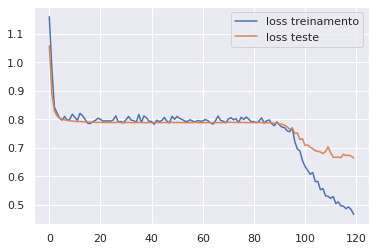

In [ ]:

sns.set()

plt.plot(np.array(losses_train), label='loss treinamento')
plt.plot(np.array(losses_test), label='loss teste')
plt.legend()
plt.show()